In [1]:
import sys
sys.path.append('/home/lumargot/trachoma/src/py')

import os 
os.environ["CUDA_VISIBLE_DEVICES"] = "-1" # put -1 to not use any

In [2]:
import math
import pandas as pd
import numpy as np 
import seaborn as sns

import torch

import matplotlib.pyplot as plt
import SimpleITK as sitk

In [3]:
def read_data(dataframe, mount_point):

  list_class = []
  list_files = []
  list_heights = []
  list_x = []
  for idx, row in dataframe.iterrows():
    seg_path = os.path.join(mount_point, row['seg'])
    npy = seg_path.replace('seg', 'segmentation_heights').replace('.nrrd', '.npy')
    if os.path.exists(npy):
      data = np.load(npy,allow_pickle=True).item()
      x_values = data['x_values']
      heights = data['heights']

      valid_indices = ~np.isnan(heights)
      heights = heights[valid_indices]
      x_values = x_values[valid_indices]

      xmin = np.min(x_values)
      xmax = np.max(x_values)

      new_x = np.linspace(xmin, xmax, num=400)
      new_y = np.interp(new_x, x_values, heights)
      list_heights.append(new_y)
      list_x.append(new_x)

      list_class.append(row['class'])
      list_files.append(npy)

  all_heights = np.stack(list_heights, axis=0)
  all_x = np.stack(list_x, axis=0)
  all_classes = np.array(list_class)

  return all_heights, all_x, all_classes, list_files

def compute_eye_bbx(seg, label=1, pad=0.01):

  shape = seg.shape
  
  ij = torch.argwhere(seg.squeeze() != 0)

  bb = torch.tensor([0, 0, 0, 0])# xmin, ymin, xmax, ymax

  bb[0] = torch.clip(torch.min(ij[:,1]) - shape[1]*pad, 0, shape[1])
  bb[1] = torch.clip(torch.min(ij[:,0]) - shape[0]*pad, 0, shape[0])
  bb[2] = torch.clip(torch.max(ij[:,1]) + shape[1]*pad, 0, shape[1])
  bb[3] = torch.clip(torch.max(ij[:,0]) + shape[0]*pad, 0, shape[0])
  
  return bb

In [4]:
df_train = pd.read_csv('/CMF/data/lumargot/trachoma/mtss_seg.csv')
df_val = pd.read_csv('/CMF/data/lumargot/trachoma/mtss_seg_train_test.csv')
df_test = pd.read_csv('/CMF/data/lumargot/trachoma/mtss_seg_test.csv')

seg_column='seg'
class_column='class'
mount_point='/CMF/data/lumargot/trachoma/PoPP_Data/mtss'
drop_labels=['Reject', 'Short Incision']
concat_labels=['overcorrection', 'Gap', 'ECA', 'Fleshy']
df_train = df_train.loc[df_train['drop']==0]

In [5]:
df_all_labels = pd.read_csv('/CMF/data/lumargot/trachoma/csv_mtss_pret/csv_updated/mtss_pret_combined.csv')
# df_all_labels = pd.read_csv('/CMF/data/lumargot/trachoma/PoPP_Data/mtss/csv/set_062025/new_annotations_mtss.csv')
df_all_labels = df_all_labels.loc[df_all_labels['class']!=3]
df_all_labels = df_all_labels.loc[df_all_labels['to_drop']==0]

In [6]:
if drop_labels is not None:
    df_all_labels = df_all_labels[ ~ df_all_labels['label'].isin(drop_labels)]

if concat_labels is not None:
    replacement_val = df_all_labels.loc[ df_all_labels['label'] == concat_labels[0]]['class'].unique()
    df_all_labels.loc[ df_all_labels['label'].isin(concat_labels), 'class' ] = replacement_val[0]

unique_classes = sorted(df_all_labels['class'].unique())
class_mapping = {value: idx for idx, value in enumerate(unique_classes)}

df_all_labels['class'] = df_all_labels['class'].map(class_mapping)


In [7]:
df_all_labels['to_drop'].value_counts()

to_drop
0    26692
Name: count, dtype: int64

In [8]:
df_all_labels['name_img'] = df_all_labels['filename'].apply(lambda filename: os.path.basename(filename))

In [9]:
drop = []
new_outcome = []
for idx, row in df_train.iterrows():
  img_name = os.path.basename(row['img'])

  all_labels_subjects = df_all_labels.loc[df_all_labels['name_img'] == img_name]

  if len(all_labels_subjects)> 0:
    drop.append(0)
    unique_labels = np.unique(all_labels_subjects['class'], return_counts=False)

    if len(unique_labels) == 2:
      if 0 in unique_labels:
        outcome = max(unique_labels)
      else: #conflict
        outcome = 4
    elif len(unique_labels) == 3: #conflict 
      outcome = 4
    else:
      outcome = unique_labels[0]

    new_outcome.append(outcome)
  else:
    drop.append(1)
    new_outcome.append('na')

In [10]:
# df_train = pd.read_csv('/CMF/data/lumargot/trachoma/PoPP_Data/new_seg_list.csv')

In [11]:
df_train['drop'] = drop
df_train['new_label'] = new_outcome

In [12]:
df_train = df_train.loc[df_train['drop']==0]
df_train = df_train.loc[df_train['new_label']!=4]

df_train['new_label'].value_counts()

new_label
0    517
2    283
1    142
Name: count, dtype: int64

In [13]:
all_heights_train, all_x_train, all_classes_train,files = read_data(df_train, mount_point)
# all_heights_test, all_x_test, all_classes_test, _ = read_data(df_test, mount_point)

### 1. Visualize data

In [18]:
  # l_classes.append(class_name)
  # l_mean.append(np.mean(ratio))
  # l_std.append(np.std(ratio))
  # l_max.append(np.max(ratio))
  # l_min.append(np.min(ratio))

  # l_middle_mean.append(np.mean(ratio[100:300]))
  # l_middle_std.append(np.std(ratio[100:300]))
  # l_middle_max.append(np.max(ratio[100:300]))
  # l_middle_min.append(np.min(ratio[100:300]))

  # l_left_mean.append(np.mean(ratio[:100]))
  # l_left_std.append(np.std(ratio[:100]))
  # l_left_max.append(np.max(ratio[:100]))
  # l_left_min.append(np.min(ratio[:100]))

  # l_right_mean.append(np.mean(ratio[300:]))
  # l_right_std.append(np.std(ratio[300:]))
  # l_right_max.append(np.max(ratio[300:]))
  # l_right_min.append(np.min(ratio[300:]))

l_ratio = []
l_classes = []
l_mean = []
l_std = []
l_min = []
l_max = []

l_middle_std = []
l_middle_mean = []
l_middle_max = []
l_middle_min = []

l_left_std = []
l_left_mean = []
l_left_max = []
l_left_min = []

l_right_std = []
l_right_mean = []
l_right_max = []
l_right_min = []


In [35]:
import seaborn as sns

In [ ]:
def get_outcome(outcome, val):
  if outcome is None:
    outcome = val
  return outcome

def global_curve_analysis(ratio, outcome, cpt_count):
  ### if the global mean is too low or too high, it means it's either overcorrection or entropion
  ### the 50 first and last are excluded because of the unperfect height computation --> excluded cause very low 

  global_mean = np.mean(ratio[50:350])

  if global_mean < 0.09:
    outcome = get_outcome(outcome, 'entropion G') 
    cpt_count.append(1)
  elif global_mean > 0.125:
    outcome = get_outcome(outcome, 'overcorrection G')
    cpt_count.append(-1)
  else:
    cpt_count.append(0)
  
  return outcome, cpt_count



def middle_side_analysis(ratio, outcome, cpt_count):
  # comparing height between left and right of middle section -> it should be similar.

  val_left = ratio[100:150]
  val_right = ratio[250:300]
  
  # if the left has an appropriate correction
  if (0.12 < np.mean(val_left) < 0.15): 
    if np.mean(val_right) < 0.10:
      # if right to low it's undercorrected
      outcome = get_outcome(outcome, 'entropion R')
      cpt_count.append(1)
    elif np.mean(val_right) > 0.15:
      # if right to high it's overcorrected
      outcome = get_outcome(outcome, 'overcorrection R')
      cpt_count.append(-1)
    else:
      cpt_count.append(0)

  # if left side is undercorrected and the right has an appropriate size
  elif  (0.10 < np.mean(val_left)) and ( np.mean(val_right) > 0.12 ): 
    outcome = get_outcome(outcome, 'entropion L')
    cpt_count.append(1)

  # if left side is overcorrected and the right has an appropriate size
  elif (np.mean(val_left)> 0.15) and ( np.mean(val_right) < 0.12 ):
    outcome = get_outcome(outcome, 'overcorrection L')
    cpt_count.append(-1)

  return outcome, cpt_count


def mean_analysis(mean_df, outcome, cpt_count):
  
  mean_left = mean_df.iloc[0]['mean']
  mean_middle = mean_df.iloc[1]['mean']
  mean_right =  mean_df.iloc[2]['mean']

  if ( mean_middle < mean_left) or (mean_middle < mean_right):
    ### if the sides mean are higher than the middle correction --> the middle section is probably undercorrected
    outcome = get_outcome(outcome, 'entropion M')
    cpt_count.append(1)

  ## Here we're checking in more details the height differences between the middle and the side section.
  diff_left =  np.abs(mean_left-mean_middle) / mean_middle
  diff_right =  np.abs(mean_right-mean_middle) / mean_middle

  diff_diff = np.abs(diff_right - diff_left) / max(diff_left, diff_right)

  # if similar correction for middle and side
  if diff_left <= 0.1 and diff_right <= 0.1:
    if mean_middle > 0.12:
      outcome = get_outcome(outcome, 'overcorrection M')
      cpt_count.append(-1)

    elif mean_middle < 0.12:
      outcome = get_outcome(outcome, 'entropion M')
      cpt_count.append(1)

  if diff_left < 0.1 and diff_right > 0.3:
    outcome = get_outcome(outcome, "overcorrection L")
    cpt_count.append(-1)

  elif diff_right < 0.1 and diff_left > 0.3:
    outcome = get_outcome(outcome, "overcorrection R")
    cpt_count.append(-1)

  if diff_left > 0.40:
    if mean_left < 0.06:
      outcome = get_outcome(outcome, 'entropion L')
      cpt_count.append(1)

    if mean_middle > 0.12:
      outcome = get_outcome(outcome, 'overcorrection M')
      cpt_count.append(-1)

  elif diff_right > 0.40:
    if mean_right < 0.06:
      outcome = get_outcome(outcome, 'entropion R')
      cpt_count.append(1)

    if mean_middle > 0.12:
      outcome = get_outcome(outcome, 'overcorrection M')
      cpt_count.append(-1)

  return outcome, cpt_count


def max_analysis(dataframe, outcome, cpt_count):
  maxs = dataframe['max'].tolist()

  if maxs[1] > 0.145:
    outcome = get_outcome(outcome, 'overcorrection M')
    cpt_count.append(-1)

  if maxs[0] > 0.145:
    outcome = get_outcome(outcome, 'overcorrection L')
    cpt_count.append(-1)

  if maxs[2] > 0.145:
    outcome = get_outcome(outcome, 'overcorrection R')
    cpt_count.append(-1)
  
  if maxs[0] < 13 and maxs[1] < 13 and maxs[2] < 13:
    cpt_count.append(0)

  return outcome, cpt_count


def adjust_classes_probabilities_based(cpt_count):
  mean_count =  np.mean(cpt_count)

  class_adjusted = 0
  if mean_count < 0:
    text = f"2 p: {np.abs(mean_count)}"
    if np.abs(mean_count) <0.4:
      class_adjusted = 0
    else:
      class_adjusted = 2
  elif mean_count > 0 :
    text = f"1 p: {np.abs(mean_count)}"
    class_adjusted = 1

  else:
    class_adjusted = 0
  return class_adjusted

In [196]:
l_gt = []
l_classes = []
l_predicted = []
l_advanced_label = []
# for IDX in range(400,500):
for IDX in range(len(all_heights_train)):

  heights = all_heights_train[IDX]
  x_values = all_x_train[IDX]
  name_seg = os.path.join('seg', os.path.basename(files[IDX])).replace('.npy', '.nrrd')

  row = df_train.loc[ df_train['seg'] == name_seg]
  class_name = row['new_label'].item()

  img = os.path.join(mount_point, row['img'].item())
  seg = os.path.join(mount_point, name_seg)

  img= sitk.GetArrayFromImage(sitk.ReadImage(img)).copy()
  seg_t = torch.tensor(sitk.GetArrayFromImage(sitk.ReadImage(seg)).copy())
  bb = compute_eye_bbx(seg_t)


  real_length = all_x_train[IDX][-1] - all_x_train[IDX][0]
  array_lenght = len(all_x_train[IDX])
  ratio = all_heights_train[IDX] /real_length

  outcome =None
  index = np.arange(len(ratio))
  bins = pd.cut(index, bins=[0,100,300,400], right=False,
                labels=["0-100", "100-300", "300-400"])

  count_df = pd.DataFrame({"bin": bins, "value": ratio})

  mean_per_bin = count_df.groupby("bin",observed=False)["value"].mean().reset_index(name="mean")
  max_per_bin = count_df.groupby("bin",observed=False)["value"].max().reset_index(name="max")
  
  merged = mean_per_bin.merge(max_per_bin, on="bin")

  mean_max_df = merged.melt(id_vars="bin", value_vars=["mean", "max"], var_name="stat", value_name="value")


  cpt_count = []
  outcome, cpt_count = global_curve_analysis(ratio, outcome, cpt_count)
  outcome, cpt_count = middle_side_analysis(ratio, outcome, cpt_count)
  outcome, cpt_count = mean_analysis(mean_per_bin, outcome, cpt_count)
  outcome, cpt_count = max_analysis(merged, outcome, cpt_count)

  if outcome == None :
    outcome = get_outcome(outcome, 'Healthy')
    cpt_count.append(0)

  class_adjusted = adjust_classes_probabilities_based(cpt_count)
  l_advanced_label.append(outcome)
  l_classes.append(class_name)
  l_predicted.append(class_adjusted)

  # plt.figure(figsize=(12,5))
  # plt.subplot(221)
  # plt.title(f'cropped image: {name_seg}')
  # plt.imshow(img[bb[1]:bb[3],bb[0]:bb[2]])

  # plt.subplot(222)
  # plt.title('cropped seg')
  # plt.imshow(seg_t[bb[1]:bb[3],bb[0]:bb[2]])
  # plt.title(f'{class_name}')

  # plt.subplot(223)
  # # plt.plot(all_x_train[IDX], gradient)
  # # plt.title(f'1st derivative heights')
  # sns.barplot(data=mean_max_df, x="bin", y="value", hue="stat")
  # plt.title(f"{class_adjusted}")

  # plt.subplot(224)
  # plt.plot(all_x_train[IDX], ratio)
  # plt.title('height ratio divided by eyelid length')

  # plt.tight_layout()
  # # plt.savefig(f'example_{IDX}_class{class_name}.png')
  # plt.show()

In [ ]:
# l_predicted = []
# for elt in l_advanced_label:
#   if 'overcorrection' in elt:
#     l_predicted.append(2)
#   elif 'entropion' in elt:
#     l_predicted.append(1)
#   else:
#     l_predicted.append(0)

In [197]:
df_out = pd.DataFrame(data={'advanced_label':l_advanced_label, 'gt':l_classes, 'pred':l_predicted})

In [130]:
from sklearn.metrics import classification_report, confusion_matrix
from evaluation import plot_confusion_matrix


In [199]:
df_out

,advanced_label,gt,pred
0,overcorrection M,0,0
1,overcorrection G,0,2
2,overcorrection G,2,2
3,Healthy,2,0
4,Healthy,0,0
...,...,...,...
926,entropion R,0,0
927,overcorrection G,0,0
928,entropion L,0,0
929,entropion L,0,0


              precision    recall  f1-score   support

           0       0.68      0.40      0.50       508
           1       0.36      0.69      0.47       140
           2       0.51      0.66      0.57       283

    accuracy                           0.52       931
   macro avg       0.52      0.58      0.51       931
weighted avg       0.58      0.52      0.52       931

Confusion matrix, without normalization
Normalized confusion matrix, avg: 0.5795424644357617


/tmp/ipykernel_21468/1102813381.py:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(122)


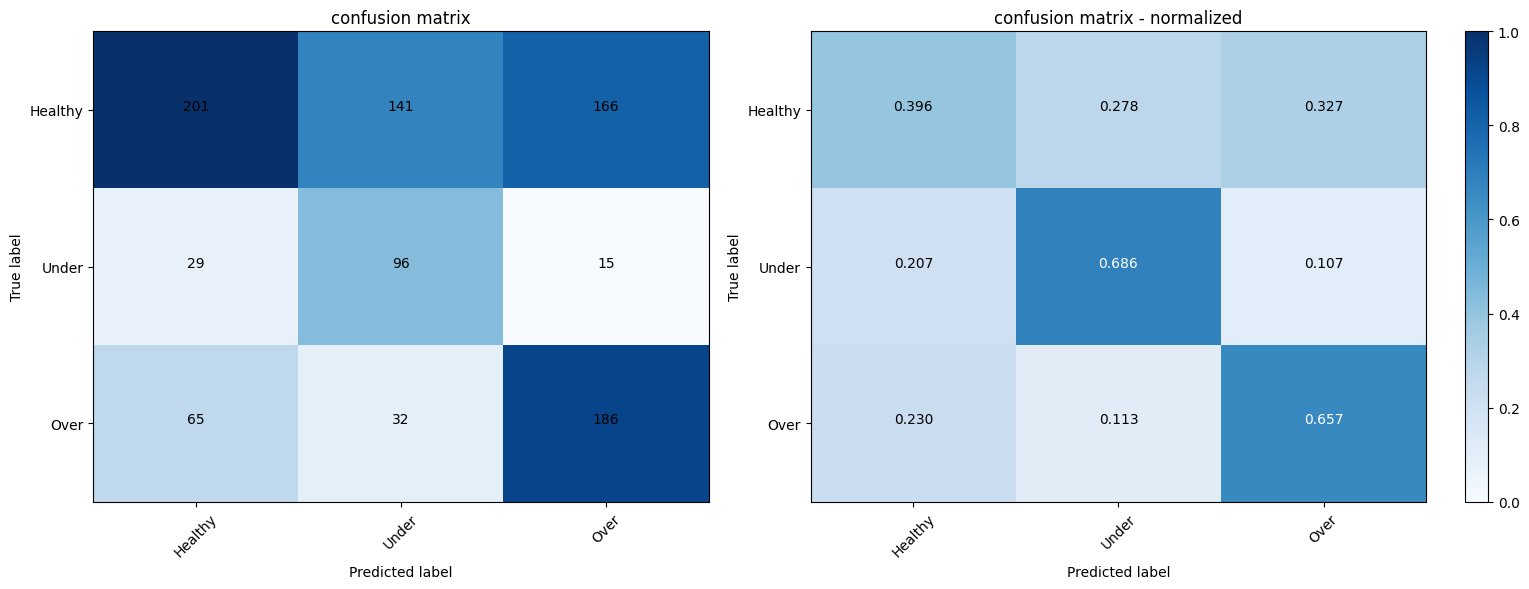

In [198]:
print(classification_report(df_out['gt'], df_out['pred'] ))
class_names = ['Healthy', 'Under', 'Over']

fig = plt.figure(figsize=(16,6))
plt.subplot(121)
cnf_matrix = confusion_matrix(df_out['gt'], df_out['pred'])
plot_confusion_matrix(cnf_matrix, classes=class_names, title='confusion matrix')
plt.subplot(122)
cm = plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='confusion matrix - normalized')

In [75]:
df = pd.DataFrame(data = {'classes': l_classes,
                          'mean': l_mean,
                          'std': l_std,
                          'min': l_min,
                          'max': l_max,
                          'middle_std': l_middle_std,
                          'middle_mean': l_middle_mean,
                          'middle_max': l_middle_max,
                          'middle_min': l_middle_min,
                          'left_std': l_left_std,
                          'left_mean': l_left_mean,
                          'left_max': l_left_max,
                          'left_min': l_left_min,
                          'right_std': l_right_std,
                          'right_mean': l_right_mean,
                          'right_max': l_right_max,
                          'right_min': l_right_min,
})

In [76]:
# df = pd.read_csv('all_heights_data_stats.csv')
df = df.loc[df['classes'] != 'ECA/PTT' ]

<Axes: xlabel='middle_mean', ylabel='Count'>

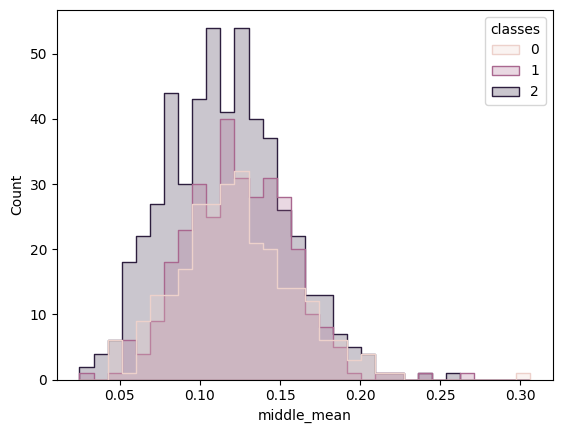

In [78]:
sns.histplot(df, x='middle_mean', hue="classes", element="step")